## Prep

In [59]:
import pandas as pd
import re
import numpy as np
from nltk.tokenize import word_tokenize
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertModel
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime
from sklearn.metrics import f1_score
import pickle
import os

In [43]:
np.random.seed(1)

df = pd.read_csv("/home/ubuntu/Development/punctuation/transcripts.csv")
# len(df): 2467

# train:val:test = 0.8:0.1:0.1
num_train = int(len(df)*0.1)+2 # 0.8 -> 0.1 for fast training for now
num_val = int(len(df)*0.1)
num_test = int(len(df)*0.1)

# assign indices
id_all = np.random.choice(len(df), len(df), replace=False)
id_train = id_all[0:num_train]
id_val = id_all[num_train : num_val+num_train]
id_test = id_all[num_val+num_train : num_val+num_train+num_test]

# actual split
train_set = df.iloc[id_train]
val_set = df.iloc[id_val]
test_set = df.iloc[id_test]

# remove transcripts containing ♫
train_set = train_set[~train_set['transcript'].str.contains('♫')]
val_set = val_set[~val_set['transcript'].str.contains('♫')]
test_set = test_set[~test_set['transcript'].str.contains('♫')]

In [17]:
def data_prep(data_set):

    # Dataset Cleanup
    data_set = data_set.drop('url',axis=1)
    data_set = data_set['transcript']
    data_set = data_set.str.replace("\(.*?\)", " ")\
    .str.replace("\[.*?\]", " ")\
    .str.replace(";", ". ")\
    .str.replace(":", ". ")\
    .str.replace('"', ' ')\
    .str.replace('!', '. ')\
    .str.replace(" — (?=[a-z])", ", ")\
    .str.replace(" — (?=[A-Z])", ". ")\
    .str.replace("(?<=[a-z])\.(?=[A-Z])", ". ")\
    .str.replace("(?<=[a-z])\?(?=[A-Z])", ". ")\
    .str.replace("(?<= )'(?=[a-zA-Z])", " ")\
    .str.replace("(?<=[a-z])\'(?= )", " ")\
    .str.replace("\'(?= )", " ")\
    .str.replace(" — ", " ")\
    .str.replace('\.+', '.')\
    .str.replace(' +', ' ')\
    .str.lower()
    # hyphens are hard to handle. for now sentences like below still have an issue:
    # one - on - one tutoring works best so that's what we tried to emulate like with me and my mom even though we knew it would be one - on - thousands 

    temp_list_1 = []
    for sentences in data_set:
        temp_list_1 += re.split('(?<=\.)|(?<=\?)',sentences)

    temp_list_2 = []
    for item in temp_list_1:
        temp_list_2.append(re.sub('^ ','',item))

    temp_list_3 = []
    for s in temp_list_2:
        try:
            if s[-1] == ".":
                temp_list_3.append(s)
            elif s[-1] == "?":
                temp_list_3.append(s)
            else:
                pass
        except:
            pass

    del data_set
    del temp_list_1
    del temp_list_2

    total_words = 0
    combined_text = ""
    outer_list = []

    # create outer_list, a list of sentences that don't go beyond 400 words
    for s in temp_list_3:
        if total_words + len(word_tokenize(s)) < 400:
            combined_text += (s + " ")
            total_words += len(word_tokenize(s))
        else:
            outer_list.append(combined_text)
            combined_text = ""
            total_words = 0        

    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    encoded_data_data = tokenizer.batch_encode_plus(outer_list, max_length=450, padding='max_length', truncation=True, return_tensors='pt')

    punc_mask_outer = []
    ids_no_punc_outer = []
    attention_mask_outer = []

    for j in range(len(encoded_data_data['input_ids'])):

        # punctuation mask for sentences
        punc_mask = []
        for i in encoded_data_data['input_ids'][j]:
            if i == 1012:
                punc_mask.pop()
                punc_mask.append(1) # period
            elif i == 1029:
                punc_mask.pop()
                punc_mask.append(2) # question mark
            elif i == 1010:
                punc_mask.pop()
                punc_mask.append(3) # comma
            else:
                punc_mask.append(0)
        punc_mask_outer.append(torch.tensor(punc_mask))

        # sentences converted to word ids excluding punctuations
        # len(punc_mask) should be the same as len(ids_no_punc)
        ids_no_punc = []
        for i in encoded_data_data['input_ids'][j]:
            if i == 1012:
                pass
            elif i == 1029:
                pass
            elif i == 1010:
                pass
            else:
                ids_no_punc.append(i)
        ids_no_punc_outer.append(torch.tensor(ids_no_punc))

        # attention_mask with subwords set to 0 except for the last one
        attention_mask = []
        first_hash = True
        for i in encoded_data_data['input_ids'][j]:
            if (i == 101 or i == 102 or i == 0): # CLS, SEP, PAD
                attention_mask.append(0)
            elif (i == 1029 or i == 1010 or i == 1012):
                pass
            else:
                if re.match(r'^##', tokenizer.decode([i])):         
                    if first_hash == True:
                        attention_mask.pop()
                        attention_mask.append(0)
                        first_hash == False
                    attention_mask.append(1)
                else:
                    if first_hash == False:
                        attention_mask.pop()
                    attention_mask.append(1)                
        attention_mask_outer.append(torch.tensor(attention_mask))

    # figure out max length so that PADs can be added till it reaches max
    token_lengths = []
    for i in range(len(punc_mask_outer)):
        token_lengths.append(len(punc_mask_outer[i]))
    token_length_max = np.max(token_lengths)

    for i in range(len(punc_mask_outer)):
        # add PAD again because length is not equal after removing punctuations
        zeros = [0] * (token_length_max - len(punc_mask_outer[i]))

        punc_mask = torch.cat((punc_mask_outer[i], torch.tensor(zeros)), 0)
        ids_no_punc = torch.cat((ids_no_punc_outer[i], torch.tensor(zeros)), 0)
        attention_mask = torch.cat((attention_mask_outer[i], torch.tensor(zeros)), 0)

        if i != 0:
            pass
            punc_mask_outer_adjusted = torch.cat((punc_mask_outer_adjusted, punc_mask.view(1,-1)),0)
            ids_no_punc_outer_adjusted = torch.cat((ids_no_punc_outer_adjusted, ids_no_punc.view(1,-1)),0)
            attention_mask_outer_adjusted = torch.cat((attention_mask_outer_adjusted, attention_mask.view(1,-1)),0)
        else:
            punc_mask_outer_adjusted = punc_mask.view(1,-1)
            ids_no_punc_outer_adjusted = ids_no_punc.view(1,-1)
            attention_mask_outer_adjusted = attention_mask.view(1,-1)
            
    return ids_no_punc_outer_adjusted, attention_mask_outer_adjusted, punc_mask_outer_adjusted, punc_mask_outer, tokenizer

In [26]:
# for i, t in enumerate(punc_mask_outer):
#     if i != 0:
#         list_cat = torch.cat([list_cat, t])
#     else:
#         list_cat = t
        
# import pandas as pd

# dx = pd.Series(list_cat)
# dx.value_counts()

# 0    52016
# 3     3508
# 1     3286
# 2      272 ... 0.46%

0    52016
3     3508
1     3286
2      272
dtype: int64

## Train and Val with Early Stopping

In [73]:
ids_no_punc_outer_adjusted, attention_mask_outer_adjusted, punc_mask_outer_adjusted, punc_mask_outer, tokenizer_train = data_prep(train_set)
ids_no_punc_outer_adjusted_val, attention_mask_outer_adjusted_val, punc_mask_outer_adjusted_val, punc_mask_outer_val, tokenizer_val = data_prep(val_set)

class DistilBERT_Arch(nn.Module):
    def __init__(self, distilbert):
        super().__init__()
        self.distilbert = distilbert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 4)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, input_ids, mask):        
        cls_hs = self.distilbert(input_ids, attention_mask=mask)[0]
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size = 3
epochs = 200

dataset_train = TensorDataset(ids_no_punc_outer_adjusted, attention_mask_outer_adjusted, punc_mask_outer_adjusted)
dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)

distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased",
                                                    num_labels=4,  
                                                    output_attentions=False,
                                                    output_hidden_states=False)
model = DistilBERT_Arch(distilbert)
optimizer = AdamW(model.parameters(),
                 lr=1e-5,
                 eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps=0,
                                           num_training_steps=len(dataloader_train)*epochs)

# prep for class_weights
for i, p in enumerate(punc_mask_outer):    
    if i != 0:
        punc_cat = torch.cat((punc_cat, p), dim=0)
    else:
        punc_cat = p
        
class_weights = compute_class_weight('balanced', np.unique(punc_cat), punc_cat.numpy())
#TODO: haven't considered attention_mask yet!!
weights = torch.tensor(class_weights, dtype=torch.float)
weights = weights.to(device)
cross_entropy = nn.NLLLoss(weight=weights)

patience_cnt = 0
prev_f1 = 0

param_list = []

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f'Started: {current_time}')
print()

val_f1_list = []
val_f1_micro_list = []
val_f1_macro_list = []
val_f1_weighted_list = []

os.makedirs('./val_results', exist_ok=True)

for epoch in range(epochs):

    if patience_cnt <= 2:
    
        nume = 0
        deno = 0
        loss_total = 0

        for batch in dataloader_train:

            model.train()
            model.zero_grad()

            batch = [b.to(device) for b in batch]

            model.to(device)

            outputs = model(batch[0].to(torch.long), batch[1].to(torch.long))

            loss = cross_entropy(outputs.to(torch.float32).view(-1, 4), batch[2].to(torch.long).view(-1))

            loss.backward()
            optimizer.step()
            scheduler.step()

            model.eval()

            loss_total += loss

            for j in range(outputs.shape[0]):
            # for jth sample in a batch

                preds = np.argmax(outputs[j].to('cpu').detach().numpy(), axis=1)
                labels = batch[2].to(torch.long)[j].to('cpu').detach().numpy()

                # for ith token in a jth sample
                # if attention mask is not 0, check if predictinon matches label
                for i in range(len(batch[1][j])):
                    if batch[1][j][i] != 0:
                        if preds[i] == labels[i]:
                            nume += 1
                        deno += 1

        loss = loss_total/len(dataloader_train)
        acc = nume/deno    
        print(f'epoch: {epoch+1}, tr_loss: {loss.item():.3f}, tr_acc: {acc:.3f}', flush=True)

        with torch.no_grad():

            model.eval()

            dataset_val = TensorDataset(ids_no_punc_outer_adjusted_val, attention_mask_outer_adjusted_val, punc_mask_outer_adjusted_val)
            dataloader_val = DataLoader(dataset_val, sampler=RandomSampler(dataset_val), batch_size=batch_size)

            val_nume = 0
            val_deno = 0

            val_preds_cat = []
            val_labels_cat = []
            
            for val_batch in dataloader_val:

                val_batch = [b.to(device) for b in val_batch]
                val_outputs = model(val_batch[0].to(torch.long), val_batch[1].to(torch.long))

                for j in range(val_outputs.shape[0]):
                # for jth sample in a batch

                    val_preds = np.argmax(val_outputs[j].to('cpu').detach().numpy(), axis=1)
                    val_labels = val_batch[2].to(torch.long)[j].to('cpu').detach().numpy()

                    # for ith token in a jth sample
                    # if attention mask is not 0, check if predictinon matches label
                    for i in range(len(val_batch[1][j])):
                        if val_batch[1][j][i] != 0:
                            if val_preds[i] == val_labels[i]:
                                val_nume += 1
                                
                            val_preds_cat.append(val_preds[i])
                            val_labels_cat.append(val_labels[i])
                                
                            val_deno += 1
                      
            val_preds_cat = np.array(val_preds_cat)
            val_labels_cat = np.array(val_labels_cat)

            val_acc = val_nume/val_deno    
            val_f1 = f1_score(val_labels_cat, val_preds_cat, average=None)
            val_f1_micro = f1_score(val_labels_cat, val_preds_cat, average='micro')
            val_f1_macro = f1_score(val_labels_cat, val_preds_cat, average='macro')
            val_f1_weighted = f1_score(val_labels_cat, val_preds_cat, average='weighted')
                        
            val_f1_list.append(val_f1)
            val_f1_micro_list.append(val_f1_micro)
            val_f1_macro_list.append(val_f1_macro)
            val_f1_weighted_list.append(val_f1_weighted)
              
            print(f'val_acc: {val_acc:.4f}', flush=True)
            print(f'val_f1: {val_f1}', flush=True)
            print(f'val_f1_micro: {val_f1_micro:.4f}', flush=True)
            print(f'val_f1_macro: {val_f1_macro:.4f}', flush=True)
            print(f'val_f1_weighted: {val_f1_weighted:.4f}', flush=True)
            print()
                               
            if prev_f1 >= val_f1_macro:
                patience_cnt += 1
            else:
                patience_cnt = 0
            
            prev_f1 = val_f1_macro
            param_list.append(model)
                
            torch.save(param_list, 'val_results/distilbert_result.pt')
            
            f = open('val_results/val_f1.txt', 'wb')
            pickle.dump(val_f1_list, f)
            
            f = open('val_results/val_f1_micro_list.txt', 'wb')
            pickle.dump(val_f1_micro_list, f)
            
            f = open('val_results/val_f1_macro_list.txt', 'wb')
            pickle.dump(val_f1_macro_list, f)

            f = open('val_results/val_f1_weighted_list.txt', 'wb')
            pickle.dump(val_f1_weighted_list, f)

    else:
        print(f'3 consecutive degraded at epoch {epoch+1}', flush=True)
        break

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f'Completed: {current_time}', flush=True)

Started: 00:10:30
epoch: 1, tr_loss: 5.877, tr_acc: 0.402
val_acc: 0.669
val_f1: [0.83920368 0.34408602 0.         0.11764706]
val_f1_micro: 0.692
val_f1_macro: 0.325
val_f1_weighted: 0.763

epoch: 2, tr_loss: 5.212, tr_acc: 0.759
val_acc: 0.842
val_f1: [0.92098093 0.51282051 0.         0.11764706]
val_f1_micro: 0.828
val_f1_macro: 0.388
val_f1_weighted: 0.864

epoch: 3, tr_loss: 4.889, tr_acc: 0.817
val_acc: 0.842
val_f1: [0.9660787  0.51282051 0.2        0.33333333]
val_f1_micro: 0.887
val_f1_macro: 0.503
val_f1_weighted: 0.909

epoch: 4, tr_loss: 4.755, tr_acc: 0.818
val_acc: 0.830
val_f1: [0.95810056 0.375      0.         0.48780488]
val_f1_micro: 0.868
val_f1_macro: 0.455
val_f1_weighted: 0.894

epoch: 5, tr_loss: 4.628, tr_acc: 0.822
val_acc: 0.819
val_f1: [0.95211268 0.42105263 0.23529412 0.44705882]
val_f1_micro: 0.864
val_f1_macro: 0.514
val_f1_weighted: 0.883

epoch: 6, tr_loss: 4.502, tr_acc: 0.827
val_acc: 0.824
val_f1: [0.94214876 0.46153846 0.         0.32911392]
val_f1_m

### Train Result from punc_train.py

1.25% of total train set + 100% of val set\
early stopping on val_f1_macro didn't kick in\
2 hours 36 mins

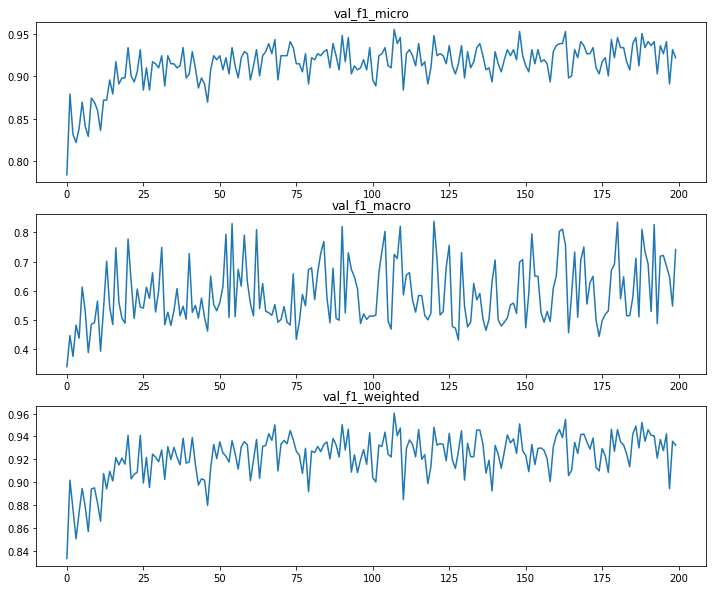

In [66]:
import matplotlib.pyplot as plt

val_f1_micro = [0.7843601895734598, 0.8791469194312796, 0.8317535545023697, 0.8222748815165877, 0.8388625592417062, 0.8696682464454977, 0.8412322274881517, 0.8293838862559242, 0.8744075829383886, 0.8696682464454977, 0.8601895734597157, 0.8364928909952607, 0.8720379146919431, 0.8720379146919431, 0.8957345971563981, 0.8791469194312796, 0.9170616113744076, 0.8909952606635071, 0.8981042654028436, 0.8981042654028436, 0.933649289099526, 0.9004739336492891, 0.8933649289099526, 0.9052132701421801, 0.9312796208530806, 0.8838862559241705, 0.909952606635071, 0.8838862559241705, 0.9170616113744076, 0.9146919431279621, 0.909952606635071, 0.9241706161137441, 0.8886255924170616, 0.9241706161137441, 0.9146919431279621, 0.9146919431279621, 0.909952606635071, 0.9123222748815166, 0.933649289099526, 0.8981042654028436, 0.9028436018957346, 0.9289099526066351, 0.909952606635071, 0.8862559241706162, 0.8981042654028436, 0.8909952606635071, 0.8696682464454977, 0.9075829383886256, 0.9241706161137441, 0.919431279620853, 0.9241706161137441, 0.9075829383886256, 0.9218009478672986, 0.9028436018957346, 0.933649289099526, 0.9123222748815166, 0.8981042654028436, 0.9218009478672986, 0.9289099526066351, 0.9265402843601894, 0.8957345971563981, 0.9123222748815166, 0.9312796208530806, 0.9004739336492891, 0.9241706161137441, 0.9289099526066351, 0.9383886255924171, 0.9265402843601894, 0.943127962085308, 0.8957345971563981, 0.9241706161137441, 0.9241706161137441, 0.9241706161137441, 0.9407582938388626, 0.933649289099526, 0.9146919431279621, 0.9146919431279621, 0.9052132701421801, 0.9265402843601894, 0.8909952606635071, 0.9218009478672986, 0.919431279620853, 0.9265402843601894, 0.9241706161137441, 0.9289099526066351, 0.9312796208530806, 0.909952606635071, 0.9383886255924171, 0.9241706161137441, 0.9075829383886256, 0.9478672985781991, 0.9170616113744076, 0.9454976303317536, 0.9028436018957346, 0.9123222748815166, 0.9075829383886256, 0.909952606635071, 0.919431279620853, 0.9075829383886256, 0.933649289099526, 0.8957345971563981, 0.8886255924170616, 0.9241706161137441, 0.9265402843601894, 0.933649289099526, 0.9123222748815166, 0.909952606635071, 0.9549763033175356, 0.9383886255924171, 0.9454976303317536, 0.8838862559241705, 0.9265402843601894, 0.9312796208530806, 0.9241706161137441, 0.9123222748815166, 0.9383886255924171, 0.9123222748815166, 0.9170616113744076, 0.8909952606635071, 0.909952606635071, 0.9478672985781991, 0.9241706161137441, 0.9265402843601894, 0.9241706161137441, 0.9146919431279621, 0.9360189573459715, 0.9123222748815166, 0.9028436018957346, 0.9146919431279621, 0.9360189573459715, 0.8981042654028436, 0.9289099526066351, 0.909952606635071, 0.9170616113744076, 0.933649289099526, 0.9383886255924171, 0.9241706161137441, 0.9075829383886256, 0.909952606635071, 0.8933649289099526, 0.9289099526066351, 0.9146919431279621, 0.9052132701421801, 0.919431279620853, 0.9312796208530806, 0.9241706161137441, 0.9312796208530806, 0.919431279620853, 0.95260663507109, 0.9241706161137441, 0.9123222748815166, 0.9052132701421801, 0.9312796208530806, 0.9146919431279621, 0.9312796208530806, 0.9170616113744076, 0.919431279620853, 0.9146919431279621, 0.8933649289099526, 0.9289099526066351, 0.9360189573459715, 0.9383886255924171, 0.9383886255924171, 0.95260663507109, 0.8981042654028436, 0.9004739336492891, 0.9312796208530806, 0.9218009478672986, 0.9407582938388626, 0.9360189573459715, 0.9265402843601894, 0.9265402843601894, 0.933649289099526, 0.909952606635071, 0.9028436018957346, 0.9170616113744076, 0.9218009478672986, 0.9004739336492891, 0.943127962085308, 0.9218009478672986, 0.9454976303317536, 0.933649289099526, 0.933649289099526, 0.9170616113744076, 0.9075829383886256, 0.9383886255924171, 0.9454976303317536, 0.9123222748815166, 0.9502369668246445, 0.933649289099526, 0.9407582938388626, 0.9360189573459715, 0.9407582938388626, 0.9028436018957346, 0.9360189573459715, 0.9265402843601894, 0.9407582938388626, 0.8909952606635071, 0.9312796208530806, 0.9218009478672986]
val_f1_macro = [0.3406173868968787, 0.4469648535494643, 0.3756577761758875, 0.48295598080080837, 0.4381569264732937, 0.6132178167102096, 0.5305691877753069, 0.3887357301098993, 0.4860734463276837, 0.4906302942097883, 0.5650901525658807, 0.39349442713866434, 0.5413719072255658, 0.7018203403244955, 0.543403699105838, 0.48507376529644713, 0.7476093055880291, 0.5621574397530944, 0.506349770823455, 0.48939938547162154, 0.7777505825325459, 0.6334486786636739, 0.5056359880318751, 0.6063264221158958, 0.5444373529059795, 0.5413343048809385, 0.6124458559288907, 0.5744959011309947, 0.6620761103519724, 0.5278153153153153, 0.6006814264167205, 0.7490565946916439, 0.4840817296269898, 0.5270988716771849, 0.48191804094625484, 0.5322058461804378, 0.6078967819622025, 0.5150066607172881, 0.5474464804063861, 0.5032548085349466, 0.7278030734206032, 0.5264370152084815, 0.5501934106976123, 0.5070977011494253, 0.5755007899581105, 0.5090256211180124, 0.46236974262397995, 0.6506056554853346, 0.5525755439392898, 0.5323600805631548, 0.5603262340333406, 0.6140517849131578, 0.7937040494806862, 0.5093005952380952, 0.8305755299882815, 0.5119770580296896, 0.673727794960249, 0.6162999926769817, 0.7907207714659423, 0.6314850278338906, 0.5567232083323753, 0.5145677131168073, 0.8097865249504594, 0.5395875759390776, 0.6251513424969731, 0.5301766331730631, 0.5253133028127265, 0.5164358887763144, 0.5533157439728575, 0.4927944214876033, 0.5020455212805638, 0.5466077388402169, 0.49215241534166776, 0.48344534842589315, 0.658529563889384, 0.4341168179745471, 0.49471524211298606, 0.5880636604774536, 0.5485085128816933, 0.6730942445066179, 0.6791784557346127, 0.5701043562338146, 0.6641086491163413, 0.729337825161794, 0.7693344391457599, 0.5789830157995822, 0.4910358565737052, 0.6779334870579066, 0.5060932337474987, 0.49955551941892296, 0.8199899291675812, 0.5244749322493225, 0.7306076633404253, 0.6732859104218328, 0.6482008310881775, 0.6075396825396826, 0.48794763109117556, 0.5212703962703963, 0.5024729855562052, 0.5143955966410274, 0.5132666135099273, 0.5172669035314384, 0.6627540981967184, 0.7361431923619653, 0.8038015155975791, 0.49673684210526314, 0.4691644562334218, 0.725188706489582, 0.7107523374646663, 0.8211738696334331, 0.5865347887406711, 0.6549322493224932, 0.6624622180888167, 0.5687535734705547, 0.5273817253583887, 0.5843729582228372, 0.5841277324867624, 0.5156829846032372, 0.5010342598577893, 0.5235710461848926, 0.8381714670994256, 0.710216014512552, 0.5177889171701158, 0.5286241610738255, 0.6803026368253169, 0.7562417091572359, 0.47799887028858995, 0.472721619176843, 0.4319348387144997, 0.7311432395239345, 0.5466150096402197, 0.47690725504861636, 0.4932795698924732, 0.6252297396622228, 0.568995612687357, 0.5910934153683112, 0.5050447264406075, 0.4649738074266376, 0.5023516431411168, 0.6319170279269588, 0.7056903319874384, 0.5010732634980953, 0.4798613805231659, 0.49247673119613566, 0.5076775720888309, 0.5522637612889383, 0.5582431784612992, 0.5227471810642065, 0.6986865342163355, 0.7074647884383312, 0.4737110752914243, 0.5912700140684665, 0.7952316076294278, 0.6503925917075383, 0.649990237381816, 0.5256911153723234, 0.4926684499952001, 0.5295613090673117, 0.4953757084229041, 0.609129869454413, 0.6518572865377686, 0.8036471932715686, 0.8112348484848485, 0.7574697444604066, 0.4566428349996125, 0.5882227563608723, 0.7331206804891015, 0.5097461097461098, 0.7060398499843658, 0.7502638874840823, 0.5548925438596491, 0.6284020813280756, 0.6500600339014974, 0.49974818932823595, 0.44427310196574055, 0.4985157588158062, 0.5191414742683097, 0.5319568665433327, 0.6702645980761481, 0.6912904838552336, 0.8351043865822191, 0.5729817812683656, 0.648218775253659, 0.5148256297034874, 0.5153261304521808, 0.5764725965858041, 0.7115771958537915, 0.5112812911725955, 0.8103833427109289, 0.7341729534260241, 0.6926783926783927, 0.5294258373205741, 0.8272789959707403, 0.48787034268522755, 0.7186869928694369, 0.7214354107301529, 0.6849237664725712, 0.6487807698348185, 0.5483240025415386, 0.741862968591692]
val_f1_weighted = [0.8331839722847885, 0.9017467194905835, 0.8764127262586915, 0.8503982670921713, 0.8736785906206649, 0.8945076404533118, 0.8782354161596477, 0.8568075426579986, 0.8939925562963558, 0.8950067587428072, 0.8821222499030441, 0.8659042641569299, 0.9075499116534834, 0.8940697965917538, 0.9094658366465214, 0.9010919049396046, 0.9214456361426212, 0.9150609225512794, 0.9210186614651568, 0.915734849935665, 0.9408938177276496, 0.9029483588948259, 0.9068506714648347, 0.908707932404615, 0.9409359078894858, 0.8992302146738204, 0.9215169549785105, 0.8953162713371815, 0.9244919855313711, 0.9218858076085563, 0.9178623764489391, 0.9282227252549654, 0.9024810297050216, 0.9311265372933847, 0.9199127207839071, 0.930434326857031, 0.9219209069166989, 0.9151559161960214, 0.9384700936861582, 0.9166365819652569, 0.91775574299507, 0.9389845141220925, 0.9158154256963448, 0.8974364002832707, 0.9029206433341366, 0.9017498380972006, 0.8796467959645725, 0.9121906778456947, 0.9330166549913632, 0.9205762516044895, 0.9352839510511395, 0.9256233383238672, 0.9225969211550434, 0.9175623448431507, 0.9361651840778085, 0.925104412507755, 0.9113555024796975, 0.9308833002905063, 0.9353950561308952, 0.93267376207867, 0.9012336571456779, 0.9190467808164703, 0.9374078450490541, 0.9032864157809727, 0.9312563309009396, 0.9321333577488827, 0.9423679777446926, 0.9365090035655731, 0.9501195425078424, 0.9098233520034468, 0.9331966135786407, 0.9364865639711567, 0.9336716871957383, 0.9451330015071324, 0.9371721688951699, 0.9270968906785584, 0.923585044663813, 0.9076811732147572, 0.9296265938154438, 0.8917343859891631, 0.9272464138204314, 0.9258738267039934, 0.9312185818940864, 0.9266903615589458, 0.9328928426487222, 0.9352186449248916, 0.9203906713398085, 0.9382125031611225, 0.9326689021320066, 0.9219295625956052, 0.9502341400899958, 0.928164213514173, 0.9463364099988814, 0.9087827051499807, 0.9238492354711603, 0.9083389754005867, 0.9193833476300971, 0.9284238668124924, 0.9156032332047283, 0.9431781279503799, 0.9038280814009472, 0.9002101269129816, 0.9324718395842069, 0.931343841950828, 0.9437760019825168, 0.9244170616113744, 0.9220398003695929, 0.9603281678333669, 0.940627727643244, 0.9473457755280968, 0.8846294213174615, 0.9294463067853428, 0.9369646759102644, 0.9329172720033847, 0.9221021780577636, 0.9460493780611291, 0.9200158037654926, 0.924019529883266, 0.8986954315083671, 0.9136264403786433, 0.9479894726660931, 0.9324113506425988, 0.9336265997912242, 0.9331877604249499, 0.9187814011377112, 0.9426016630212498, 0.9197080613499977, 0.9120097219632127, 0.926850094976049, 0.944908415756597, 0.9017656006823238, 0.934008195471931, 0.9223666106099985, 0.9221967159612292, 0.9455492688567388, 0.9455632911937677, 0.9335502037411871, 0.9079330551967592, 0.9191654708990701, 0.8922943401782643, 0.9321180836836276, 0.9244768747523024, 0.9121391013875743, 0.9264766051361246, 0.9413525887251982, 0.9343438454399636, 0.937837150105352, 0.9251418908146262, 0.9509744410616949, 0.9275637852005041, 0.9234613708149118, 0.9091745626503963, 0.9329721795351918, 0.9153241032653386, 0.9294610689529488, 0.9299323406324265, 0.9278105654431201, 0.920489074866195, 0.9003837686292416, 0.9305178415917388, 0.9408077923582111, 0.9460660332796514, 0.938978026712624, 0.9548442957440053, 0.9057688648769364, 0.9103061594919898, 0.9348496186610429, 0.9251041217865862, 0.9416315991262311, 0.9420785701484206, 0.935312837781658, 0.9289900108554306, 0.9386161530191122, 0.9130372362648985, 0.9098174647100783, 0.929376213889775, 0.9229926740423114, 0.9085450655845839, 0.9461743632287719, 0.9269858945676783, 0.9460643940530943, 0.9351877946576179, 0.9326045030718237, 0.9245377422675389, 0.9135218068269961, 0.942070779201424, 0.9490823217319132, 0.9299339989634653, 0.9522694194004866, 0.9358291356761022, 0.9457988794481684, 0.9409895916007165, 0.9404651330898168, 0.9210475299669509, 0.9372443379605407, 0.9275380434238057, 0.9422065051254453, 0.8942816400296509, 0.9357929869420524, 0.93230539669735]

fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(range(len(val_f1_micro)), val_f1_micro)
ax2.plot(range(len(val_f1_macro)), val_f1_macro)
ax3.plot(range(len(val_f1_weighted)), val_f1_weighted)

ax1.set_title('val_f1_micro')
ax2.set_title('val_f1_macro')
ax3.set_title('val_f1_weighted');

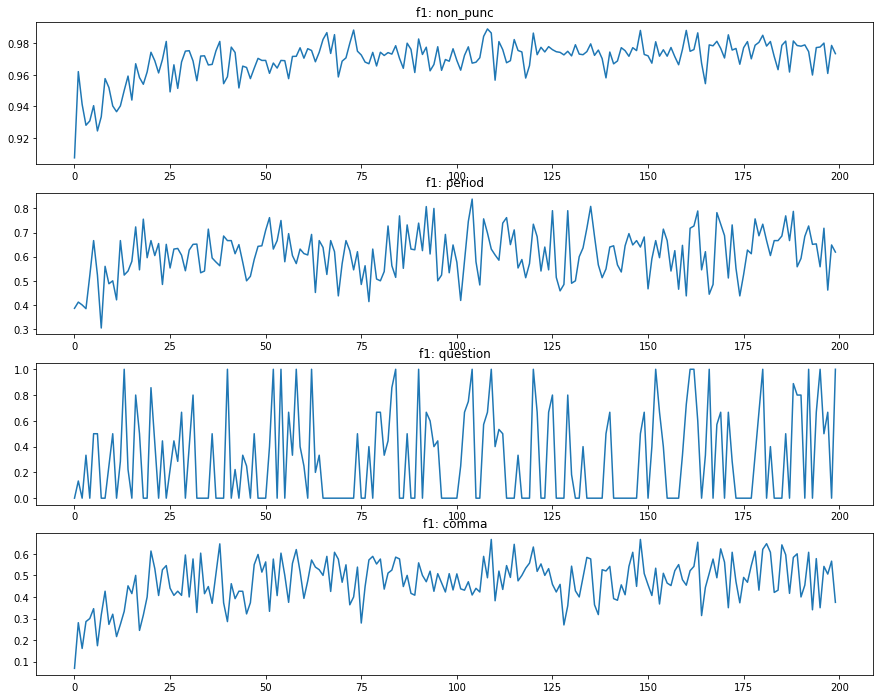

In [69]:
import re
#val_f1 = "[array([0.90753912, 0.38596491, 0.        , 0.06896552]), array([0.96205962, 0.41176471, 0.13333333, 0.28070175]), array([0.94134078, 0.4       , 0.        , 0.16129032]), array([0.92816092, 0.38461538, 0.33333333, 0.28571429]), array([0.93088858, 0.52173913, 0.        , 0.3       ]), array([0.94052559, 0.66666667, 0.5       , 0.34567901]), array([0.92455418, 0.52380952, 0.5       , 0.17391304]), array([0.93352192, 0.30434783, 0.        , 0.31707317]), array([0.95762712, 0.56      , 0.        , 0.42666667]), array([0.95198903, 0.48780488, 0.25      , 0.27272727]), array([0.94036061, 0.5       , 0.5       , 0.32      ]), array([0.93670886, 0.42105263, 0.        , 0.21621622]), array([0.9403794 , 0.66666667, 0.28571429, 0.27272727]), array([0.9501385 , 0.52380952, 1.        , 0.33333333]), array([0.95923913, 0.54054054, 0.22222222, 0.4516129 ]), array([0.94406548, 0.58064516, 0.        , 0.41558442]), array([0.96703297, 0.72340426, 0.8       , 0.5       ]), array([0.95827725, 0.54545455, 0.5       , 0.24489796]), array([0.95405405, 0.75555556, 0.        , 0.31578947]), array([0.96185286, 0.59574468, 0.        , 0.4       ]), array([0.97428958, 0.66666667, 0.85714286, 0.61290323]), array([0.96892655, 0.60465116, 0.42857143, 0.53164557]), array([0.96121884, 0.65454545, 0.        , 0.40677966]), array([0.96969697, 0.48484848, 0.44444444, 0.52631579]), array([0.98113208, 0.65116279, 0.        , 0.54545455]), array([0.94924554, 0.55319149, 0.22222222, 0.44067797]), array([0.96635262, 0.63157895, 0.44444444, 0.40740741]), array([0.95145631, 0.63414634, 0.28571429, 0.42666667]), array([0.96816976, 0.60606061, 0.66666667, 0.40740741]), array([0.975     , 0.54166667, 0.        , 0.59459459]), array([0.97527473, 0.62745098, 0.4       , 0.4       ]), array([0.9687924 , 0.65116279, 0.8       , 0.57627119]), array([0.95628415, 0.65217391, 0.        , 0.32786885]), array([0.97188755, 0.53333333, 0.        , 0.6031746 ]), array([0.97203728, 0.54054054, 0.        , 0.41509434]), array([0.96626181, 0.71428571, 0.        , 0.44827586]), array([0.96662216, 0.59459459, 0.5       , 0.37037037]), array([0.97520661, 0.57777778, 0.        , 0.50704225]), array([0.98113208, 0.5625    , 0.        , 0.64615385]), array([0.95442359, 0.68571429, 0.        , 0.37288136]), array([0.95883134, 0.66666667, 1.        , 0.28571429]), array([0.97754293, 0.66666667, 0.        , 0.46153846]), array([0.97414966, 0.6122449 , 0.22222222, 0.39215686]), array([0.95172414, 0.65      , 0.        , 0.42666667]), array([0.96551724, 0.57692308, 0.33333333, 0.42622951]), array([0.96467391, 0.5       , 0.25      , 0.32142857]), array([0.95762712, 0.51851852, 0.        , 0.37333333]), array([0.96418733, 0.58823529, 0.5       , 0.55      ]), array([0.97043011, 0.64285714, 0.        , 0.59701493]), array([0.96912752, 0.64516129, 0.        , 0.51515152]), array([0.96912752, 0.70967742, 0.        , 0.5625    ]), array([0.96096904, 0.76190476, 0.4       , 0.33333333]), array([0.96747967, 0.63157895, 1.        , 0.57575758]), array([0.96428571, 0.66666667, 0.        , 0.40625   ]), array([0.96912752, 0.75      , 1.        , 0.6031746 ]), array([0.96896086, 0.57894737, 0.        , 0.5       ]), array([0.95759234, 0.69565217, 0.66666667, 0.375     ]), array([0.97165992, 0.60465116, 0.33333333, 0.55555556]), array([0.9717362 , 0.57142857, 1.        , 0.61971831]), array([0.97711978, 0.63157895, 0.4       , 0.51724138]), array([0.97054698, 0.61290323, 0.25      , 0.39344262]), array([0.97655172, 0.60714286, 0.        , 0.47457627]), array([0.97540984, 0.69230769, 1.        , 0.57142857]), array([0.96827586, 0.4516129 , 0.2       , 0.53846154]), array([0.97428958, 0.66666667, 0.33333333, 0.52631579]), array([0.98240866, 0.63829787, 0.        , 0.5       ]), array([0.98670213, 0.52631579, 0.        , 0.58823529]), array([0.97354497, 0.66666667, 0.        , 0.42553191]), array([0.98543046, 0.62068966, 0.        , 0.60714286]), array([0.95867769, 0.4375    , 0.        , 0.575     ]), array([0.96866841, 0.57142857, 0.        , 0.46808511]), array([0.97074468, 0.66666667, 0.        , 0.54901961]), array([0.9799733 , 0.625     , 0.        , 0.36363636]), array([0.98832685, 0.54545455, 0.        , 0.4       ]), array([0.97496706, 0.62068966, 0.5       , 0.53846154]), array([0.97254902, 0.48484848, 0.        , 0.27906977]), array([0.96808511, 0.5625    , 0.        , 0.44827586]), array([0.96703297, 0.4137931 , 0.4       , 0.57142857]), array([0.97421981, 0.63157895, 0.        , 0.58823529]), array([0.96561605, 0.50746269, 0.66666667, 0.55263158]), array([0.97428958, 0.5       , 0.66666667, 0.57575758]), array([0.97225892, 0.53846154, 0.33333333, 0.43636364]), array([0.97407913, 0.72727273, 0.44444444, 0.5106383 ]), array([0.97311828, 0.5625    , 0.85714286, 0.52459016]), array([0.97843666, 0.51428571, 1.        , 0.58461538]), array([0.97043011, 0.76923077, 0.        , 0.57627119]), array([0.96414343, 0.55172414, 0.        , 0.44827586]), array([0.98002663, 0.73170732, 0.5       , 0.5       ]), array([0.97612732, 0.63157895, 0.        , 0.41666667]), array([0.96148738, 0.62857143, 0.        , 0.40816327]), array([0.98268975, 0.73913043, 1.        , 0.55813953]), array([0.97289973, 0.625     , 0.        , 0.5       ]), array([0.97748344, 0.80769231, 0.66666667, 0.47058824]), array([0.96255201, 0.61111111, 0.6       , 0.51948052]), array([0.96657382, 0.8       , 0.4       , 0.42622951]), array([0.97777778, 0.5       , 0.44444444, 0.50793651]), array([0.96286472, 0.52380952, 0.        , 0.46511628]), array([0.96969697, 0.69230769, 0.        , 0.42307692]), array([0.9686221 , 0.53333333, 0.        , 0.50793651]), array([0.97650131, 0.64864865, 0.        , 0.43243243]), array([0.96910112, 0.57692308, 0.        , 0.50704225]), array([0.96296296, 0.41860465, 0.25      , 0.4375    ]), array([0.97233202, 0.58064516, 0.66666667, 0.43137255]), array([0.97771588, 0.74626866, 0.75      , 0.47058824]), array([0.96740548, 0.83870968, 1.        , 0.40909091]), array([0.968     , 0.57894737, 0.        , 0.44      ]), array([0.97082228, 0.48275862, 0.        , 0.42307692]), array([0.9843342 , 0.75675676, 0.57142857, 0.58823529]), array([0.9890411 , 0.6984127 , 0.66666667, 0.48888889]), array([0.98644986, 0.63157895, 1.        , 0.66666667]), array([0.95664336, 0.60714286, 0.4       , 0.38235294]), array([0.98102981, 0.58536585, 0.53333333, 0.52      ]), array([0.97593583, 0.73913043, 0.5       , 0.43478261]), array([0.96765499, 0.76190476, 0.        , 0.54545455]), array([0.96896086, 0.65      , 0.        , 0.49056604]), array([0.98231293, 0.71111111, 0.        , 0.6440678 ]), array([0.97540984, 0.55319149, 0.33333333, 0.47457627]), array([0.97449664, 0.58823529, 0.        , 0.5       ]), array([0.95798319, 0.51282051, 0.        , 0.53333333]), array([0.96589359, 0.57142857, 0.        , 0.55696203]), array([0.98641304, 0.73469388, 1.        , 0.63157895]), array([0.97275204, 0.68292683, 0.66666667, 0.51851852]), array([0.97742364, 0.54054054, 0.        , 0.55319149]), array([0.97449664, 0.64      , 0.        , 0.5       ]), array([0.97783934, 0.54545455, 0.66666667, 0.53125   ]), array([0.97593583, 0.79069767, 0.8       , 0.45833333]), array([0.97463284, 0.51428571, 0.        , 0.42307692]), array([0.97421981, 0.45833333, 0.        , 0.45833333]), array([0.9726206 , 0.48484848, 0.        , 0.27027027]), array([0.97490092, 0.79069767, 0.8       , 0.35897436]), array([0.9719888 , 0.48979592, 0.18181818, 0.54285714]), array([0.97905759, 0.5       , 0.        , 0.42857143]), array([0.97311828, 0.6       , 0.        , 0.4       ]), array([0.97275204, 0.63636364, 0.4       , 0.49180328]), array([0.9747004 , 0.71794872, 0.        , 0.58333333]), array([0.97959184, 0.80851064, 0.        , 0.57627119]), array([0.97233202, 0.68421053, 0.        , 0.36363636]), array([0.97567568, 0.56603774, 0.        , 0.31818182]), array([0.97027027, 0.51282051, 0.        , 0.52631579]), array([0.95810056, 0.54901961, 0.5       , 0.52054795]), array([0.97442799, 0.64      , 0.66666667, 0.54166667]), array([0.9669749 , 0.64516129, 0.        , 0.39215686]), array([0.9687924 , 0.56603774, 0.        , 0.38461538]), array([0.97718121, 0.53658537, 0.        , 0.45614035]), array([0.97529259, 0.64516129, 0.        , 0.41025641]), array([0.9717362 , 0.69565217, 0.        , 0.54166667]), array([0.97718121, 0.64864865, 0.        , 0.60714286]), array([0.97534247, 0.66666667, 0.        , 0.44897959]), array([0.98807947, 0.64      , 0.5       , 0.66666667]), array([0.97289973, 0.68181818, 0.66666667, 0.50847458]), array([0.97203728, 0.46666667, 0.        , 0.45614035]), array([0.9673913 , 0.59090909, 0.4       , 0.40677966]), array([0.98092643, 0.66666667, 1.        , 0.53333333]), array([0.97181208, 0.59574468, 0.66666667, 0.36734694]), array([0.97587131, 0.71428571, 0.4       , 0.50980392]), array([0.97181208, 0.66666667, 0.        , 0.46428571]), array([0.97730307, 0.54054054, 0.        , 0.45283019]), array([0.97150611, 0.625     , 0.        , 0.52173913]), array([0.96638655, 0.46511628, 0.        , 0.55      ]), array([0.97612732, 0.64705882, 0.33333333, 0.48      ]), array([0.98811096, 0.4375    , 0.72727273, 0.45454545]), array([0.97490092, 0.71794872, 1.        , 0.52173913]), array([0.976     , 0.72727273, 1.        , 0.54166667]), array([0.98655914, 0.78947368, 0.6       , 0.65384615]), array([0.9673913 , 0.54545455, 0.        , 0.31372549]), array([0.95442359, 0.62068966, 0.33333333, 0.44444444]), array([0.97894737, 0.44444444, 1.        , 0.50909091]), array([0.97837838, 0.48484848, 0.        , 0.57575758]), array([0.98123324, 0.7826087 , 0.57142857, 0.48888889]), array([0.97674419, 0.73469388, 0.66666667, 0.62295082]), array([0.97066667, 0.6875    , 0.        , 0.56140351]), array([0.98531375, 0.51162791, 0.66666667, 0.35      ]), array([0.97567568, 0.73170732, 0.28571429, 0.60714286]), array([0.97668038, 0.55172414, 0.        , 0.47058824]), array([0.96671105, 0.4375    , 0.        , 0.37288136]), array([0.97718121, 0.52631579, 0.        , 0.49056604]), array([0.98102981, 0.62745098, 0.        , 0.46808511]), array([0.97012802, 0.6122449 , 0.        , 0.54545455]), array([0.9787234 , 0.75675676, 0.33333333, 0.6122449 ]), array([0.98055556, 0.68656716, 0.66666667, 0.43137255]), array([0.98503401, 0.73469388, 1.        , 0.62068966]), array([0.97820163, 0.66666667, 0.        , 0.64705882]), array([0.98108108, 0.60465116, 0.4       , 0.60714286]), array([0.97158322, 0.66666667, 0.        , 0.42105263]), array([0.96326531, 0.66666667, 0.        , 0.43137255]), array([0.97866667, 0.68571429, 0.        , 0.64150943]), array([0.98133333, 0.76923077, 0.5       , 0.59574468]), array([0.96179183, 0.66666667, 0.        , 0.41666667]), array([0.98143236, 0.78787879, 0.88888889, 0.58333333]), array([0.97855228, 0.55813953, 0.8       , 0.6       ]), array([0.97812098, 0.59259259, 0.8       , 0.4       ]), array([0.97894737, 0.68421053, 0.        , 0.45454545]), array([0.9747004 , 0.72727273, 1.        , 0.60714286]), array([0.95989305, 0.65116279, 0.        , 0.34042553]), array([0.9772423 , 0.65306122, 0.66666667, 0.57777778]), array([0.97760211, 0.55813953, 1.        , 0.35      ]), array([0.98007968, 0.71794872, 0.5       , 0.54166667]), array([0.96089385, 0.46153846, 0.66666667, 0.5060241 ]), array([0.97860963, 0.64864865, 0.        , 0.56603774]), array([0.97340426, 0.61904762, 1.        , 0.375     ])]"
#val_f1 = re.sub('array', 'np.array', val_f1)
val_f1 = [np.array([0.90753912, 0.38596491, 0.        , 0.06896552]), np.array([0.96205962, 0.41176471, 0.13333333, 0.28070175]), np.array([0.94134078, 0.4       , 0.        , 0.16129032]), np.array([0.92816092, 0.38461538, 0.33333333, 0.28571429]), np.array([0.93088858, 0.52173913, 0.        , 0.3       ]), np.array([0.94052559, 0.66666667, 0.5       , 0.34567901]), np.array([0.92455418, 0.52380952, 0.5       , 0.17391304]), np.array([0.93352192, 0.30434783, 0.        , 0.31707317]), np.array([0.95762712, 0.56      , 0.        , 0.42666667]), np.array([0.95198903, 0.48780488, 0.25      , 0.27272727]), np.array([0.94036061, 0.5       , 0.5       , 0.32      ]), np.array([0.93670886, 0.42105263, 0.        , 0.21621622]), np.array([0.9403794 , 0.66666667, 0.28571429, 0.27272727]), np.array([0.9501385 , 0.52380952, 1.        , 0.33333333]), np.array([0.95923913, 0.54054054, 0.22222222, 0.4516129 ]), np.array([0.94406548, 0.58064516, 0.        , 0.41558442]), np.array([0.96703297, 0.72340426, 0.8       , 0.5       ]), np.array([0.95827725, 0.54545455, 0.5       , 0.24489796]), np.array([0.95405405, 0.75555556, 0.        , 0.31578947]), np.array([0.96185286, 0.59574468, 0.        , 0.4       ]), np.array([0.97428958, 0.66666667, 0.85714286, 0.61290323]), np.array([0.96892655, 0.60465116, 0.42857143, 0.53164557]), np.array([0.96121884, 0.65454545, 0.        , 0.40677966]), np.array([0.96969697, 0.48484848, 0.44444444, 0.52631579]), np.array([0.98113208, 0.65116279, 0.        , 0.54545455]), np.array([0.94924554, 0.55319149, 0.22222222, 0.44067797]), np.array([0.96635262, 0.63157895, 0.44444444, 0.40740741]), np.array([0.95145631, 0.63414634, 0.28571429, 0.42666667]), np.array([0.96816976, 0.60606061, 0.66666667, 0.40740741]), np.array([0.975     , 0.54166667, 0.        , 0.59459459]), np.array([0.97527473, 0.62745098, 0.4       , 0.4       ]), np.array([0.9687924 , 0.65116279, 0.8       , 0.57627119]), np.array([0.95628415, 0.65217391, 0.        , 0.32786885]), np.array([0.97188755, 0.53333333, 0.        , 0.6031746 ]), np.array([0.97203728, 0.54054054, 0.        , 0.41509434]), np.array([0.96626181, 0.71428571, 0.        , 0.44827586]), np.array([0.96662216, 0.59459459, 0.5       , 0.37037037]), np.array([0.97520661, 0.57777778, 0.        , 0.50704225]), np.array([0.98113208, 0.5625    , 0.        , 0.64615385]), np.array([0.95442359, 0.68571429, 0.        , 0.37288136]), np.array([0.95883134, 0.66666667, 1.        , 0.28571429]), np.array([0.97754293, 0.66666667, 0.        , 0.46153846]), np.array([0.97414966, 0.6122449 , 0.22222222, 0.39215686]), np.array([0.95172414, 0.65      , 0.        , 0.42666667]), np.array([0.96551724, 0.57692308, 0.33333333, 0.42622951]), np.array([0.96467391, 0.5       , 0.25      , 0.32142857]), np.array([0.95762712, 0.51851852, 0.        , 0.37333333]), np.array([0.96418733, 0.58823529, 0.5       , 0.55      ]), np.array([0.97043011, 0.64285714, 0.        , 0.59701493]), np.array([0.96912752, 0.64516129, 0.        , 0.51515152]), np.array([0.96912752, 0.70967742, 0.        , 0.5625    ]), np.array([0.96096904, 0.76190476, 0.4       , 0.33333333]), np.array([0.96747967, 0.63157895, 1.        , 0.57575758]), np.array([0.96428571, 0.66666667, 0.        , 0.40625   ]), np.array([0.96912752, 0.75      , 1.        , 0.6031746 ]), np.array([0.96896086, 0.57894737, 0.        , 0.5       ]), np.array([0.95759234, 0.69565217, 0.66666667, 0.375     ]), np.array([0.97165992, 0.60465116, 0.33333333, 0.55555556]), np.array([0.9717362 , 0.57142857, 1.        , 0.61971831]), np.array([0.97711978, 0.63157895, 0.4       , 0.51724138]), np.array([0.97054698, 0.61290323, 0.25      , 0.39344262]), np.array([0.97655172, 0.60714286, 0.        , 0.47457627]), np.array([0.97540984, 0.69230769, 1.        , 0.57142857]), np.array([0.96827586, 0.4516129 , 0.2       , 0.53846154]), np.array([0.97428958, 0.66666667, 0.33333333, 0.52631579]), np.array([0.98240866, 0.63829787, 0.        , 0.5       ]), np.array([0.98670213, 0.52631579, 0.        , 0.58823529]), np.array([0.97354497, 0.66666667, 0.        , 0.42553191]), np.array([0.98543046, 0.62068966, 0.        , 0.60714286]), np.array([0.95867769, 0.4375    , 0.        , 0.575     ]), np.array([0.96866841, 0.57142857, 0.        , 0.46808511]), np.array([0.97074468, 0.66666667, 0.        , 0.54901961]), np.array([0.9799733 , 0.625     , 0.        , 0.36363636]), np.array([0.98832685, 0.54545455, 0.        , 0.4       ]), np.array([0.97496706, 0.62068966, 0.5       , 0.53846154]), np.array([0.97254902, 0.48484848, 0.        , 0.27906977]), np.array([0.96808511, 0.5625    , 0.        , 0.44827586]), np.array([0.96703297, 0.4137931 , 0.4       , 0.57142857]), np.array([0.97421981, 0.63157895, 0.        , 0.58823529]), np.array([0.96561605, 0.50746269, 0.66666667, 0.55263158]), np.array([0.97428958, 0.5       , 0.66666667, 0.57575758]), np.array([0.97225892, 0.53846154, 0.33333333, 0.43636364]), np.array([0.97407913, 0.72727273, 0.44444444, 0.5106383 ]), np.array([0.97311828, 0.5625    , 0.85714286, 0.52459016]), np.array([0.97843666, 0.51428571, 1.        , 0.58461538]), np.array([0.97043011, 0.76923077, 0.        , 0.57627119]), np.array([0.96414343, 0.55172414, 0.        , 0.44827586]), np.array([0.98002663, 0.73170732, 0.5       , 0.5       ]), np.array([0.97612732, 0.63157895, 0.        , 0.41666667]), np.array([0.96148738, 0.62857143, 0.        , 0.40816327]), np.array([0.98268975, 0.73913043, 1.        , 0.55813953]), np.array([0.97289973, 0.625     , 0.        , 0.5       ]), np.array([0.97748344, 0.80769231, 0.66666667, 0.47058824]), np.array([0.96255201, 0.61111111, 0.6       , 0.51948052]), np.array([0.96657382, 0.8       , 0.4       , 0.42622951]), np.array([0.97777778, 0.5       , 0.44444444, 0.50793651]), np.array([0.96286472, 0.52380952, 0.        , 0.46511628]), np.array([0.96969697, 0.69230769, 0.        , 0.42307692]), np.array([0.9686221 , 0.53333333, 0.        , 0.50793651]), np.array([0.97650131, 0.64864865, 0.        , 0.43243243]), np.array([0.96910112, 0.57692308, 0.        , 0.50704225]), np.array([0.96296296, 0.41860465, 0.25      , 0.4375    ]), np.array([0.97233202, 0.58064516, 0.66666667, 0.43137255]), np.array([0.97771588, 0.74626866, 0.75      , 0.47058824]), np.array([0.96740548, 0.83870968, 1.        , 0.40909091]), np.array([0.968     , 0.57894737, 0.        , 0.44      ]), np.array([0.97082228, 0.48275862, 0.        , 0.42307692]), np.array([0.9843342 , 0.75675676, 0.57142857, 0.58823529]), np.array([0.9890411 , 0.6984127 , 0.66666667, 0.48888889]), np.array([0.98644986, 0.63157895, 1.        , 0.66666667]), np.array([0.95664336, 0.60714286, 0.4       , 0.38235294]), np.array([0.98102981, 0.58536585, 0.53333333, 0.52      ]), np.array([0.97593583, 0.73913043, 0.5       , 0.43478261]), np.array([0.96765499, 0.76190476, 0.        , 0.54545455]), np.array([0.96896086, 0.65      , 0.        , 0.49056604]), np.array([0.98231293, 0.71111111, 0.        , 0.6440678 ]), np.array([0.97540984, 0.55319149, 0.33333333, 0.47457627]), np.array([0.97449664, 0.58823529, 0.        , 0.5       ]), np.array([0.95798319, 0.51282051, 0.        , 0.53333333]), np.array([0.96589359, 0.57142857, 0.        , 0.55696203]), np.array([0.98641304, 0.73469388, 1.        , 0.63157895]), np.array([0.97275204, 0.68292683, 0.66666667, 0.51851852]), np.array([0.97742364, 0.54054054, 0.        , 0.55319149]), np.array([0.97449664, 0.64      , 0.        , 0.5       ]), np.array([0.97783934, 0.54545455, 0.66666667, 0.53125   ]), np.array([0.97593583, 0.79069767, 0.8       , 0.45833333]), np.array([0.97463284, 0.51428571, 0.        , 0.42307692]), np.array([0.97421981, 0.45833333, 0.        , 0.45833333]), np.array([0.9726206 , 0.48484848, 0.        , 0.27027027]), np.array([0.97490092, 0.79069767, 0.8       , 0.35897436]), np.array([0.9719888 , 0.48979592, 0.18181818, 0.54285714]), np.array([0.97905759, 0.5       , 0.        , 0.42857143]), np.array([0.97311828, 0.6       , 0.        , 0.4       ]), np.array([0.97275204, 0.63636364, 0.4       , 0.49180328]), np.array([0.9747004 , 0.71794872, 0.        , 0.58333333]), np.array([0.97959184, 0.80851064, 0.        , 0.57627119]), np.array([0.97233202, 0.68421053, 0.        , 0.36363636]), np.array([0.97567568, 0.56603774, 0.        , 0.31818182]), np.array([0.97027027, 0.51282051, 0.        , 0.52631579]), np.array([0.95810056, 0.54901961, 0.5       , 0.52054795]), np.array([0.97442799, 0.64      , 0.66666667, 0.54166667]), np.array([0.9669749 , 0.64516129, 0.        , 0.39215686]), np.array([0.9687924 , 0.56603774, 0.        , 0.38461538]), np.array([0.97718121, 0.53658537, 0.        , 0.45614035]), np.array([0.97529259, 0.64516129, 0.        , 0.41025641]), np.array([0.9717362 , 0.69565217, 0.        , 0.54166667]), np.array([0.97718121, 0.64864865, 0.        , 0.60714286]), np.array([0.97534247, 0.66666667, 0.        , 0.44897959]), np.array([0.98807947, 0.64      , 0.5       , 0.66666667]), np.array([0.97289973, 0.68181818, 0.66666667, 0.50847458]), np.array([0.97203728, 0.46666667, 0.        , 0.45614035]), np.array([0.9673913 , 0.59090909, 0.4       , 0.40677966]), np.array([0.98092643, 0.66666667, 1.        , 0.53333333]), np.array([0.97181208, 0.59574468, 0.66666667, 0.36734694]), np.array([0.97587131, 0.71428571, 0.4       , 0.50980392]), np.array([0.97181208, 0.66666667, 0.        , 0.46428571]), np.array([0.97730307, 0.54054054, 0.        , 0.45283019]), np.array([0.97150611, 0.625     , 0.        , 0.52173913]), np.array([0.96638655, 0.46511628, 0.        , 0.55      ]), np.array([0.97612732, 0.64705882, 0.33333333, 0.48      ]), np.array([0.98811096, 0.4375    , 0.72727273, 0.45454545]), np.array([0.97490092, 0.71794872, 1.        , 0.52173913]), np.array([0.976     , 0.72727273, 1.        , 0.54166667]), np.array([0.98655914, 0.78947368, 0.6       , 0.65384615]), np.array([0.9673913 , 0.54545455, 0.        , 0.31372549]), np.array([0.95442359, 0.62068966, 0.33333333, 0.44444444]), np.array([0.97894737, 0.44444444, 1.        , 0.50909091]), np.array([0.97837838, 0.48484848, 0.        , 0.57575758]), np.array([0.98123324, 0.7826087 , 0.57142857, 0.48888889]), np.array([0.97674419, 0.73469388, 0.66666667, 0.62295082]), np.array([0.97066667, 0.6875    , 0.        , 0.56140351]), np.array([0.98531375, 0.51162791, 0.66666667, 0.35      ]), np.array([0.97567568, 0.73170732, 0.28571429, 0.60714286]), np.array([0.97668038, 0.55172414, 0.        , 0.47058824]), np.array([0.96671105, 0.4375    , 0.        , 0.37288136]), np.array([0.97718121, 0.52631579, 0.        , 0.49056604]), np.array([0.98102981, 0.62745098, 0.        , 0.46808511]), np.array([0.97012802, 0.6122449 , 0.        , 0.54545455]), np.array([0.9787234 , 0.75675676, 0.33333333, 0.6122449 ]), np.array([0.98055556, 0.68656716, 0.66666667, 0.43137255]), np.array([0.98503401, 0.73469388, 1.        , 0.62068966]), np.array([0.97820163, 0.66666667, 0.        , 0.64705882]), np.array([0.98108108, 0.60465116, 0.4       , 0.60714286]), np.array([0.97158322, 0.66666667, 0.        , 0.42105263]), np.array([0.96326531, 0.66666667, 0.        , 0.43137255]), np.array([0.97866667, 0.68571429, 0.        , 0.64150943]), np.array([0.98133333, 0.76923077, 0.5       , 0.59574468]), np.array([0.96179183, 0.66666667, 0.        , 0.41666667]), np.array([0.98143236, 0.78787879, 0.88888889, 0.58333333]), np.array([0.97855228, 0.55813953, 0.8       , 0.6       ]), np.array([0.97812098, 0.59259259, 0.8       , 0.4       ]), np.array([0.97894737, 0.68421053, 0.        , 0.45454545]), np.array([0.9747004 , 0.72727273, 1.        , 0.60714286]), np.array([0.95989305, 0.65116279, 0.        , 0.34042553]), np.array([0.9772423 , 0.65306122, 0.66666667, 0.57777778]), np.array([0.97760211, 0.55813953, 1.        , 0.35      ]), np.array([0.98007968, 0.71794872, 0.5       , 0.54166667]), np.array([0.96089385, 0.46153846, 0.66666667, 0.5060241 ]), np.array([0.97860963, 0.64864865, 0.        , 0.56603774]), np.array([0.97340426, 0.61904762, 1.        , 0.375     ])]

label_0 = [x[0] for x in val_f1]
label_1 = [x[1] for x in val_f1]
label_2 = [x[2] for x in val_f1]
label_3 = [x[3] for x in val_f1]

fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.plot(range(len(label_0)), label_0)
ax2.plot(range(len(label_1)), label_1)
ax3.plot(range(len(label_2)), label_2)
ax4.plot(range(len(label_3)), label_3)

ax1.set_title('f1: non_punc')
ax2.set_title('f1: period')
ax3.set_title('f1: question')
ax4.set_title('f1: comma');

## Test

In [63]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f'Started: {current_time}')

model = torch.load('distilbert_result.pt')
model.eval()

with torch.no_grad(): # is this necessary?

    ids_no_punc_outer_adjusted_test, attention_mask_outer_adjusted_test, punc_mask_outer_adjusted_test, _ = data_prep(test_set)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    batch_size = 3
    epochs = 100

    dataset_test = TensorDataset(ids_no_punc_outer_adjusted_test, attention_mask_outer_adjusted_test, punc_mask_outer_adjusted_test)
    dataloader_test = DataLoader(dataset_test, sampler=RandomSampler(dataset_test), batch_size=batch_size)

    test_nume = 0
    test_deno = 0

    test_preds_cat = []
    test_labels_cat = []
    
    for test_batch in dataloader_test:

        test_batch = [b.to(device) for b in test_batch]
        test_outputs = model(test_batch[0].to(torch.long), test_batch[1].to(torch.long))

        for j in range(test_outputs.shape[0]):
        # for jth sample in a batch

            test_preds = np.argmax(test_outputs[j].to('cpu').detach().numpy(), axis=1)
            test_labels = test_batch[2].to(torch.long)[j].to('cpu').detach().numpy()

            # for ith token in a jth sample
            # if attention mask is not 0, check if predictinon matches label
            for i in range(len(test_batch[1][j])):
                if test_batch[1][j][i] != 0:
                    if test_preds[i] == test_labels[i]:    
                        test_nume += 1
                        
                        test_preds_cat.append(test_preds[i])
                        test_labels_cat.append(test_labels[i])
                        
                    test_deno += 1

    test_preds_cat = np.array(test_preds_cat)
    test_labels_cat = np.array(test_labels_cat)
                     
    test_acc = test_nume/test_deno    
    test_f1 = f1_score(test_labels, test_preds, average=None)
    test_f1_micro = f1_score(test_labels, test_preds, average='micro')
    test_f1_macro = f1_score(test_labels, test_preds, average='macro')
    test_f1_weighted = f1_score(test_labels, test_preds, average='weighted')
    
    print(f'test_acc: {test_acc:.3f}', flush=True)
    print(f'test_f1: {test_f1}', flush=True)
    print(f'test_f1_micro: {test_f1_micro:.3f}', flush=True)
    print(f'test_f1_macro: {test_f1_macro:.3f}', flush=True)
    print(f'test_f1_weighted: {test_f1_weighted:.3f}', flush=True)
    
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print(f'Completed: {current_time}', flush=True)

Started: 23:25:22


KeyboardInterrupt: 